In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense


2025-06-28 20:12:31.595197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751141551.857470      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751141551.929818      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def generate_24hr_engine_data_improved(seed=42):
    """
    Generate 24-hour synthetic engine data with improved realism:
    - Throttle has delayed effect on RPM (inertia)
    - RPM affects pressure, temperature with lag
    - Enhanced vibration logic with resonance, sinusoidal offsets, and combined load effects
    """

    np.random.seed(seed)

    duration_min = 24 * 60
    step_sec = 30
    total_points = duration_min * 60 // step_sec  # 2880

    time = np.arange(0, total_points * step_sec, step_sec)

    # -- Phase pattern: idle, cruise, ramp, cooldown
    pattern = [0]*60 + [1]*100 + [2]*40 + [3]*40
    phases = (pattern * ((total_points // len(pattern)) + 1))[:total_points]

    # -- Throttle profile
    throttle = np.zeros(total_points)
    for i, phase in enumerate(phases):
        if phase == 0:  # idle
            throttle[i] = np.random.uniform(5, 20)
        elif phase == 1:  # cruise
            throttle[i] = np.random.uniform(35, 55)
        elif phase == 2:  # ramp
            throttle[i] = np.random.uniform(65, 100)
        elif phase == 3:  # cooldown
            throttle[i] = np.random.uniform(0, 10)

    # Smooth throttle transitions
    for i in range(1, total_points):
        max_delta = 10
        diff = throttle[i] - throttle[i-1]
        if abs(diff) > max_delta:
            throttle[i] = throttle[i-1] + np.sign(diff) * max_delta

    # -- Initialize arrays
    rpm = np.zeros(total_points)
    temp = np.zeros(total_points)
    pressure = np.zeros(total_points)
    vibration = np.zeros(total_points)

    # Initial conditions
    rpm[0] = 850
    temp[0] = 70
    pressure[0] = 1.6
    vibration[0] = 0.18

    for i in range(1, total_points):
        dt = step_sec

        # ===== RPM =====
        target_rpm = 800 + throttle[i]**1.05 * 2.2 + np.random.normal(0, 25)
        inertia = 0.3
        rpm[i] = rpm[i-1] + inertia * (target_rpm - rpm[i-1])
        rpm[i] = np.clip(rpm[i], 700, 6500)

        # ===== Temperature =====
        heat_from_rpm = (rpm[i] - 800) * 0.002
        heat_from_throttle = throttle[i] * 0.05
        ambient_cooling = 0.02 * (temp[i-1] - 20)
        temp[i] = temp[i-1] + 0.1 * (heat_from_rpm + heat_from_throttle - ambient_cooling)
        temp[i] += np.random.normal(0, 1.5)
        temp[i] = np.clip(temp[i], 60, 130)

        # ===== Pressure =====
        base = 1.3 + (throttle[i]/100)**1.25 * 2.1 + (rpm[i] / 6000) * 0.8
        pressure[i] = pressure[i-1] + 0.25 * (base - pressure[i-1]) + np.random.normal(0, 0.05)
        pressure[i] = np.clip(pressure[i], 1.0, 4.2)

        # ===== Vibration (improved) =====
        norm_throttle = throttle[i] / 100
        norm_rpm = (rpm[i] - 700) / (6500 - 700)
        base_vib = 0.12 + 0.25 * (0.7 * norm_throttle + 0.3 * norm_rpm)**1.3

        resonance = 0
        if 2900 < rpm[i] < 3300:
            resonance += 0.03 * np.sin((rpm[i] - 3000) * 0.02)
        if 4700 < rpm[i] < 5100:
            resonance += 0.025 * np.sin((rpm[i] - 4900) * 0.03)

        sinusoidal = 0.01 * np.sin(2 * np.pi * i / 48)  # 24-min cycle
        throttle_spike = abs(throttle[i] - throttle[i-1]) * 0.004
        noise = np.random.normal(0, 0.007)

        vibration[i] = base_vib + resonance + sinusoidal + throttle_spike + noise
        vibration[i] = np.clip(vibration[i], 0.12, 0.42)

    return pd.DataFrame({
        "t_sec": time,
        "throttle_pos": throttle.round(1),
        "rpm": rpm.astype(int),
        "coolant_temp": temp.round(1),
        "pressure": pressure.round(2),
        "vibration": vibration.round(3)
    })



In [4]:
# Load synthetic data
df = generate_24hr_engine_data_improved(seed=42)

# Drop time column for now
df_data = df.drop(columns=["t_sec"])

# Display head
df_data.head()


,throttle_pos,rpm,coolant_temp,pressure,vibration
0,10.6,850,70.0,1.60,0.180
1,19.3,856,69.4,1.49,0.177
2,16.0,854,70.0,1.59,0.144
3,14.0,854,71.7,1.50,0.148
4,7.3,839,71.6,1.51,0.154


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_data)

# Convert back to DataFrame for sanity
scaled_df = pd.DataFrame(scaled_data, columns=df_data.columns)
scaled_df.head()


,throttle_pos,rpm,coolant_temp,pressure,vibration
0,0.107179,0.225589,0.142857,0.147619,0.289855
1,0.195147,0.245791,0.134286,0.095238,0.275362
2,0.161780,0.239057,0.142857,0.142857,0.115942
3,0.141557,0.239057,0.167143,0.100000,0.135266
4,0.073812,0.188552,0.165714,0.104762,0.164251


In [6]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        sequences.append(window)
    return np.array(sequences)

SEQUENCE_LENGTH = 24  # 2 hours (5-min intervals)
X = create_sequences(scaled_data, SEQUENCE_LENGTH)

print("Shape of input sequence tensor:", X.shape)  # Expect (n_windows, 24, n_features)


Shape of input sequence tensor: (2856, 24, 5)


In [7]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2284, 24, 5) Test: (572, 24, 5)


In [8]:
def build_lstm_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = LSTM(64, activation="relu", return_sequences=True)(inputs)
    x = LSTM(32, activation="relu")(x)

    # Bottleneck
    encoded = RepeatVector(input_shape[0])(x)

    # Decoder
    x = LSTM(32, activation="relu", return_sequences=True)(encoded)
    x = LSTM(64, activation="relu", return_sequences=True)(x)
    outputs = TimeDistributed(Dense(input_shape[1]))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model


In [9]:
model = build_lstm_autoencoder(X_train.shape[1:])
model.summary()


2025-06-28 20:13:44.037774: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 24, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 24, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 24, 5)               │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,813 (249.27 KB)

 Trainable params: 63,813 (249.27 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.1322 - val_loss: 0.0256
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0196 - val_loss: 0.0124
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0114 - val_loss: 0.0087
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.

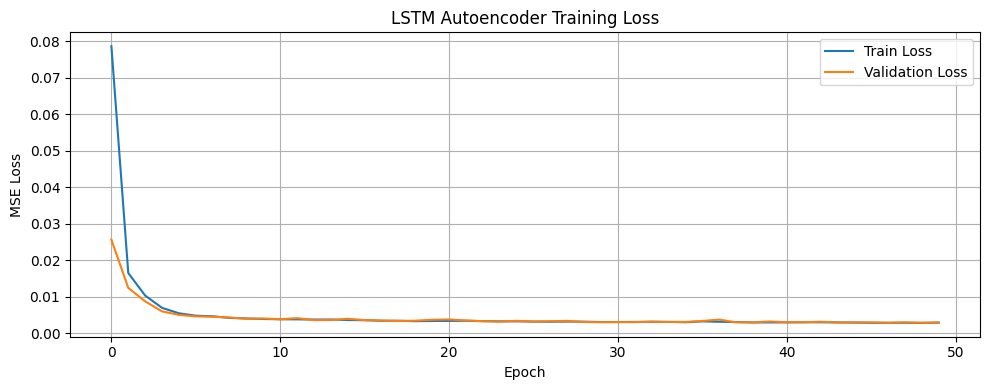

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
print(df.corr())

                 t_sec  throttle_pos       rpm  coolant_temp  pressure  \
t_sec         1.000000      0.026694  0.029747      0.732674  0.043406   
throttle_pos  0.026694      1.000000  0.964939      0.065278  0.954583   
rpm           0.029747      0.964939  1.000000      0.091491  0.975056   
coolant_temp  0.732674      0.065278  0.091491      1.000000  0.113131   
pressure      0.043406      0.954583  0.975056      0.113131  1.000000   
vibration     0.029550      0.933712  0.909105      0.082084  0.904562   

              vibration  
t_sec          0.029550  
throttle_pos   0.933712  
rpm            0.909105  
coolant_temp   0.082084  
pressure       0.904562  
vibration      1.000000  


In [18]:
X_pred = model.predict(X_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step


In [19]:
# Calculate MSE for each sequence
reconstruction_errors = np.mean(np.mean(np.square(X_test - X_pred), axis=1), axis=1)

print("Reconstruction Error Shape:", reconstruction_errors.shape)


Reconstruction Error Shape: (572,)


In [20]:
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly threshold (95th percentile): {threshold:.6f}")


Anomaly threshold (95th percentile): 0.004814


In [21]:
def classify_severity(error, threshold):
    if error < threshold:
        return "normal"
    elif error < threshold * 1.5:
        return "low"
    elif error < threshold * 2.5:
        return "medium"
    else:
        return "high"

labels = [classify_severity(e, threshold) for e in reconstruction_errors]

# Show count of each label
from collections import Counter
print(Counter(labels))


Counter({'normal': 543, 'low': 26, 'medium': 3})


In [28]:
def normalize_input(sensor_input, scaler, feature_order):
    input_array = np.array([[sensor_input[feature] for feature in feature_order]])
    scaled = scaler.transform(input_array)
    return scaled[0]


In [31]:
def detect_anomaly_lstm(sensor_input, model, scaler, feature_order, threshold):
    # Normalize input
    norm_vector = normalize_input(sensor_input, scaler, feature_order)

    # Reshape to (1, window_size, n_features) — repeat input to match expected shape
    repeated_input = np.repeat(norm_vector[np.newaxis, :], SEQUENCE_LENGTH, axis=0)
    repeated_input = repeated_input[np.newaxis, :, :]  # shape (1, 24, n_features)

    # Predict
    reconstructed = model.predict(repeated_input)[0]
    mse = np.mean((reconstructed - repeated_input[0])**2)

    status = "ANOMALY ❌" if mse > threshold else "NORMAL ✅"
    return mse, status


In [32]:
schema = {
    "rpm": (700, 6500),
    "coolant_temp": (60, 130),
    "throttle_pos": (0, 100),
    "pressure": (1.0, 4.2),
    "vibration": (0.12, 0.42),
    "air_temp": (10, 45)  # if included
}

def label_wise_diagnostics(sensor_input, schema):
    diagnostics = {}
    for key, value in sensor_input.items():
        min_val, max_val = schema.get(key, (0, 1))
        if value < min_val:
            diagnostics[key] = "LOW"
        elif value > max_val:
            diagnostics[key] = "HIGH"
        else:
            diagnostics[key] = "OK"
    return diagnostics


In [33]:
sensor_input = {
    "rpm": 7200,
    "coolant_temp": 98,
    "throttle_pos": 70,
    "pressure": 3.4,
    "vibration": 0.4,
    "air_temp": 35
}

feature_order = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]  # must match scaler

# Step 1: Anomaly detection
mse, status = detect_anomaly_lstm(sensor_input, model, scaler, feature_order, threshold)

# Step 2: Feature-wise diagnostics
diagnostics = label_wise_diagnostics(sensor_input, schema)

# Output
print(f"Status: {status} | MSE: {mse:.5f}")
print("Diagnostics:")
for k, v in diagnostics.items():
    print(f"{k}: {v}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Status: ANOMALY ❌ | MSE: 1279.66412
Diagnostics:
rpm: HIGH ⚠️
coolant_temp: OK ✅
throttle_pos: OK ✅
pressure: OK ✅
vibration: OK ✅
air_temp: OK ✅


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
def generate_alternate_fault_data(seed=2025):
    df_fault = generate_24hr_engine_data_improved(seed)

    # Anomaly: Throttle stuck at high value (unresponsive input)
    df_fault.loc[800:1000, 'throttle_pos'] = 85

    # Secondary anomaly: Coolant fails to cool (heat trap)
    df_fault.loc[800:1000, 'coolant_temp'] += np.linspace(0, 15, 201)
    
    # Add vibration anomalies due to overheat
    df_fault.loc[800:1000, 'vibration'] += np.random.normal(0.05, 0.01, size=201)

    # Clamp
    df_fault['coolant_temp'] = df_fault['coolant_temp'].clip(60, 140)
    df_fault['vibration'] = df_fault['vibration'].clip(0.12, 0.5)

    return df_fault


In [35]:
df_alt = generate_alternate_fault_data()

# Drop time
df_alt_data = df_alt.drop(columns=['t_sec'])

# Normalize using existing scaler
scaled_alt = scaler.transform(df_alt_data)

# Create sequences
X_alt = create_sequences(scaled_alt, SEQUENCE_LENGTH)


In [36]:
X_alt_pred = model.predict(X_alt)
reconstruction_errors_alt = np.mean(np.mean(np.square(X_alt - X_alt_pred), axis=1), axis=1)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Counter({'normal': 2365, 'high': 220, 'low': 215, 'medium': 56})


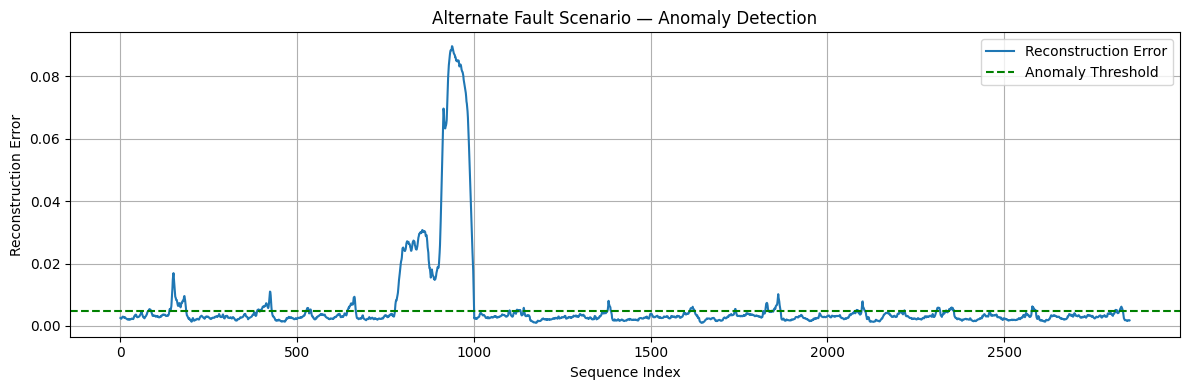

In [37]:
labels_alt = [classify_severity(e, threshold) for e in reconstruction_errors_alt]
print(Counter(labels_alt))

# Plot
plt.figure(figsize=(12, 4))
plt.plot(reconstruction_errors_alt, label="Reconstruction Error")
plt.axhline(y=threshold, color='green', linestyle='--', label="Anomaly Threshold")
plt.title("Alternate Fault Scenario — Anomaly Detection")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
i = 850
sensor_input = df_alt.iloc[i].to_dict()
sensor_input.pop('t_sec')

mse, status = detect_anomaly_lstm(sensor_input, model, scaler, feature_order, threshold)
diag = label_wise_diagnostics(sensor_input, schema)

print(f"Sample {i} — Status: {status} | MSE: {mse:.5f}")
print("Diagnostics:")
for k, v in diag.items():
    print(f"{k}: {v}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sample 850 — Status: ANOMALY ❌ | MSE: 0.03176
Diagnostics:
throttle_pos: OK ✅
rpm: OK ✅
coolant_temp: OK ✅
pressure: OK ✅
vibration: OK ✅


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
